In [1]:
import numpy as np
from numpy.fft import fft
from scipy.signal import freqz
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import ar_select_order

In [2]:
def box_muller(u1, u2):
    """u1, u2 are uniform random variables of size T
    Returns two N(0,1) random variables of size T"""
    z1 = np.sqrt(-2*np.log(1-u1))*np.cos(2*np.pi*u2)
    z2 = np.sqrt(-2*np.log(1-u1))*np.sin(2*np.pi*u2)
    return np.array([z1, z2])

In [3]:
# Initialize VAR(1) system parameters
Phi = [[.6, 0], [.3, .9]]
Sigma= [[2, 2], [2, 8]]

# Generate two U([0,1]) random varialbes 
np.random.seed(42)
T = 1000
u1, u2 = np.random.rand(T), np.random.rand(T)

# Simulate N(0,I) random vector 
iid_innov = box_muller(u1, u2)

# Generate innovations via Cholesky factorization  
L = np.linalg.cholesky(Sigma)
eps = np.dot(L, iid_innov)
eps1, eps2 = eps[0], eps[1]

# Allocate memory for y1 and y2 series 
y1, y2 = np.empty_like(eps1), np.empty_like(eps2)

# Draw y0 from unconditional distribution 
y1[0], y2[0] = eps1[0], eps2[0]

# Simulate y1 and y2 series  
for t in range(1, T):
    y1[t] = Phi[0][0]*y1[t-1] + eps1[t]
    y2[t] = Phi[1][0]*y1[t-1] + Phi[1][0]*y2[t-1] + eps2[t]

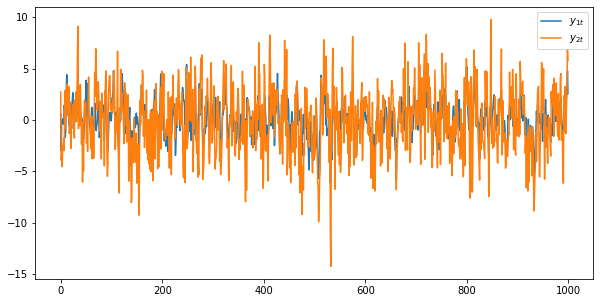

In [4]:
# Plot results
fig, ax = plt.subplots(figsize=(10,5))  

ax.plot(y1, label='$y_{1t}$')
ax.plot(y2, label='$y_{2t}$')  
ax.legend()
plt.savefig('q2-fig')

In [5]:
def sample_sdf(y):
    """y is an array of time domain data 
    Returns w, the frequencies and f_y, the sample spectral density"""
    T = len(y)
    f_y = np.abs(fft(y))**2/T
    w = 2*np.pi*np.arange(T)/T
    w, f_y = w[:int(T/2)+1], f_y[:int(T/2)+1]
    return w, f_y/(4*np.pi)

In [6]:
def unif_window(f, trunc_lag=10):
    """f is the sample spectral density
    Return the uniform lag window sample spectral density"""
    j = int(trunc_lag/2)
    fb = f[:j]
    ft = f[-j:]
    s = np.concatenate((fb[::-1], f, ft[::-1]))
    window = np.ones(trunc_lag)
    return np.convolve(window/window.sum(), s, mode='valid')

In [25]:
def ar_sdf(y, max_lag=15, i_c='bic', cst='n'):
    """y is an array of time domain data 
    Returns w, the frequencies and ar_sdf, the ar sample spectral density"""
    sel = ar_select_order(y, maxlag=max_lag, ic=i_c, trend=cst)
    res = sel.model.fit()
    ar_poly = np.insert(-res.params, 0, 1)
    w, b_fft = freqz(b=1, a=ar_poly, worN=int(len(y)/2)+1)
    ar_sdf = res.sigma2*np.abs(b_fft)**2/(4*np.pi)
    return w, ar_sdf, sel.ar_lags, res.summary()

In [22]:
# Sample SDF for y1
w_y1, f_y1 = sample_sdf(y1)

# Uniform lag window SDF for y1
f_y1_unif = unif_window(f_y1)

In [26]:
# Autoregressive estimation
ar_freq_y1, ar_sdf_y1, order_y1, y1_sum = ar_sdf(y1)

In [27]:
y1_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                     AutoReg(1)   Log Likelihood               -1726.547
Method:               Conditional MLE   S.D. of innovations              1.363
Date:                Tue, 17 Mar 2020   AIC                              0.623
Time:                        20:51:33   BIC                              0.633
Sample:                             1   HQIC                             0.626
                                 1000                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.6284      0.025     25.492      0.000       0.580       0.677
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5913           +0.0000j            1.5913            0.0000
-----------------------------------------------------------------------------
"""

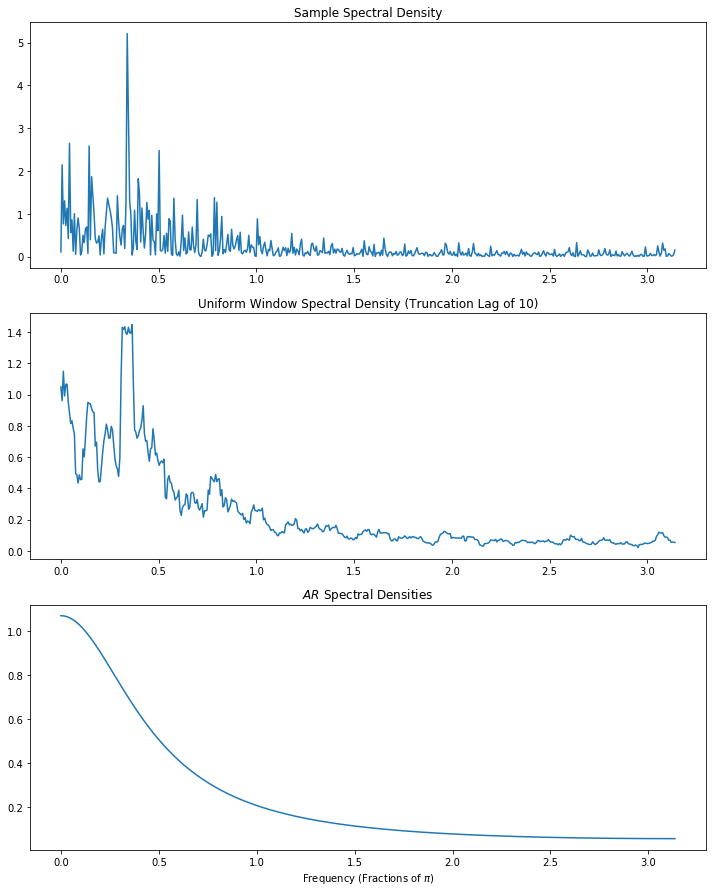

In [28]:
plt.figure(figsize=(10,12.5))

plt.subplot(311)
plt.plot(w_y1, f_y1)
plt.title('Sample Spectral Density')

plt.subplot(312)
plt.plot(w_y1, f_y1_unif[1:])
plt.title('Uniform Window Spectral Density (Truncation Lag of 10)')

plt.subplot(313)
plt.plot(ar_freq_y1, ar_sdf_y1)
plt.xlabel('Frequency (Fractions of $\pi$)')
plt.title('$AR$ Spectral Densities')

plt.tight_layout()
plt.savefig('q3-fig')

In [11]:
# First difference filter 
xt = np.diff(y1)

# Lag 3 filter
zt = np.convolve(np.ones(3)/3, y1, mode='valid')

In [29]:
# Sample SDFs
w_xt, f_xt = sample_sdf(xt)
w_zt, f_zt = sample_sdf(zt)

# Uniform lag window SDFs
f_xt_unif = unif_window(f_xt)
f_zt_unif = unif_window(f_zt)

# Autoregressive estimation 
xt_freq, ar_sdf_xt, order_xt, xt_sum = ar_sdf(xt)
zt_freq, ar_sdf_zt, order_zt, zt_sum = ar_sdf(zt)

In [33]:
zt_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  998
Model:                    AutoReg(14)   Log Likelihood                -664.229
Method:               Conditional MLE   S.D. of innovations              0.475
Date:                Tue, 17 Mar 2020   AIC                             -1.457
Time:                        21:06:00   BIC                             -1.383
Sample:                            14   HQIC                            -1.429
                                  998                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           1.5749      0.032     49.667      0.000       1.513       1.637
y.L2          -0.5893      0.059    -10.021      0.000      -0.705      -0.474
y.L3          -0.8503      0.062    -13.790      0.000      -0.971      -0.729
y.L4           1.2986      0.067     19.500      0.000       1.168       1.429
y.L5          -0.5030      0.075     -6.685      0.000      -0.650      -0.356
y.L6          -0.6170      0.076     -8.153      0.000      -0.765      -0.469
y.L7           0.9670      0.077     12.512      0.000       0.816       1.118
y.L8          -0.3826      0.077     -4.953      0.000      -0.534      -0.231
y.L9          -0.4421      0.076     -5.835      0.000      -0.591      -0.294
y.L10          0.6909      0.075      9.189      0.000       0.544       0.838
y.L11         -0.3294      0.066     -4.956      0.000      -0.460      -0.199
y.L12         -0.1281      0.062     -2.077      0.038      -0.249      -0.007
y.L13          0.2671      0.059      4.555      0.000       0.152       0.382
y.L14         -0.1001      0.032     -3.168      0.002      -0.162      -0.038
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -0.9440           -0.5977j            1.1174           -0.4102
AR.2            -0.9440           +0.5977j            1.1174            0.4102
AR.3            -1.2061           -0.1571j            1.2163           -0.4794
AR.4            -1.2061           +0.1571j            1.2163            0.4794
AR.5            -0.0732           -1.1304j            1.1327           -0.2603
AR.6            -0.0732           +1.1304j            1.1327            0.2603
AR.7             0.3805           -1.1005j            1.1644           -0.1970
AR.8             0.3805           +1.1005j            1.1644            0.1970
AR.9             0.7631           -0.8489j            1.1415           -0.1335
AR.10            0.7631           +0.8489j            1.1415            0.1335
AR.11            1.0406           -0.4436j            1.1312           -0.0641
AR.12            1.0406           +0.4436j            1.1312            0.0641
AR.13            1.2307           -0.0000j            1.2307           -0.0000
AR.14            1.5145           -0.0000j            1.5145           -0.0000
------------------------------------------------------------------------------
"""

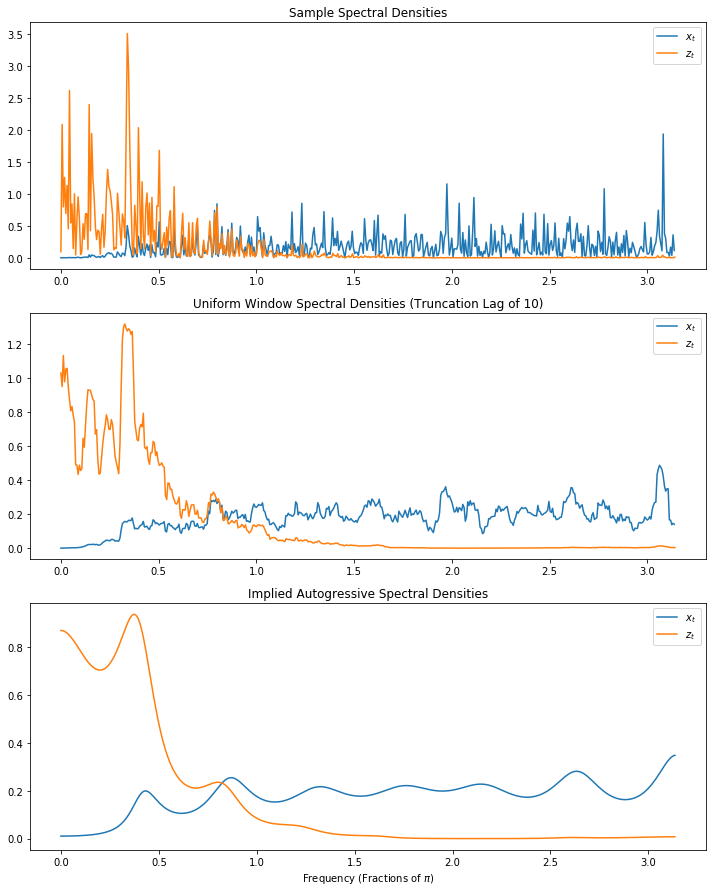

In [30]:
plt.figure(figsize=(10,12.5))

plt.subplot(311)
plt.plot(w_xt, f_xt, label='$x_t$')
plt.plot(w_zt, f_zt, label='$z_t$')
plt.legend()
plt.title('Sample Spectral Densities')

plt.subplot(312)
plt.plot(w_xt, f_xt_unif[1:], label='$x_t$')
plt.plot(w_zt, f_zt_unif[1:], label='$z_t$')
plt.legend()
plt.title('Uniform Window Spectral Densities (Truncation Lag of 10)')

plt.subplot(313)
plt.plot(xt_freq, ar_sdf_xt, label='$x_t$')
plt.plot(zt_freq, ar_sdf_zt, label='$z_t$')
plt.legend()
plt.xlabel('Frequency (Fractions of $\pi$)')
plt.title('Implied Autogressive Spectral Densities')

plt.tight_layout()
plt.savefig('q4-fig')